In [127]:
%run config.py

In [128]:
import numpy as np
import pandas as pd
from copy import deepcopy

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP modules we will use for text normalization
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer #use this to create BoW matrix

In [129]:
df = pd.read_csv('Data/customer_support_tickets.csv')

In [130]:
import pyLDAvis.lda_model


#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [131]:
df['Ticket Description'] = df.apply(lambda x: x['Ticket Description'].replace("{product_purchased}", x['Product Purchased']), axis=1)


In [132]:
df['Ticket Description']

0       I'm having an issue with the GoPro Hero. Pleas...
1       I'm having an issue with the LG Smart TV. Plea...
2       I'm facing a problem with my Dell XPS. The Del...
3       I'm having an issue with the Microsoft Office....
4       I'm having an issue with the Autodesk AutoCAD....
                              ...                        
8464    My LG OLED is making strange noises and not fu...
8465    I'm having an issue with the Bose SoundLink Sp...
8466    I'm having an issue with the GoPro Action Came...
8467    I'm having an issue with the PlayStation. Plea...
8468    There seems to be a hardware problem with my P...
Name: Ticket Description, Length: 8469, dtype: object

In [133]:
df['Ticket Description'] = df['Ticket Description'].str.lower()

In [134]:
cleaned_df = df[['Ticket ID','Product Purchased','Ticket Type','Ticket Description','Ticket Subject','Ticket Channel']]

In [135]:
cleaned_df

,Ticket ID,Product Purchased,Ticket Type,Ticket Description,Ticket Subject,Ticket Channel
0,1,GoPro Hero,Technical issue,i'm having an issue with the gopro hero. pleas...,Product setup,Social media
1,2,LG Smart TV,Technical issue,i'm having an issue with the lg smart tv. plea...,Peripheral compatibility,Chat
2,3,Dell XPS,Technical issue,i'm facing a problem with my dell xps. the del...,Network problem,Social media
3,4,Microsoft Office,Billing inquiry,i'm having an issue with the microsoft office....,Account access,Social media
4,5,Autodesk AutoCAD,Billing inquiry,i'm having an issue with the autodesk autocad....,Data loss,Email
...,...,...,...,...,...,...
8464,8465,LG OLED,Product inquiry,my lg oled is making strange noises and not fu...,Installation support,Phone
8465,8466,Bose SoundLink Speaker,Technical issue,i'm having an issue with the bose soundlink sp...,Refund request,Email
8466,8467,GoPro Action Camera,Technical issue,i'm having an issue with the gopro action came...,Account access,Social media
8467,8468,PlayStation,Product inquiry,i'm having an issue with the playstation. plea...,Payment issue,Email


In [136]:
from stop_words import get_stop_words

def process_ticket(ticket_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = list(get_stop_words('en'))         #About 900 stopwords
    nltk_words = list(stopwords.words('english')) #About 150 stopwords
    custom_words = ['please','assist','issue','product','problem','persists','unable','noticed','use','possible','using','sometimes','checked','item','facing','need','assistance']
    product_words = []
    for item in df['Product Purchased'].unique():
        for word in item.split():
            product_words.append(word.lower())    
    stop_words.extend(nltk_words)
    stop_words.extend(custom_words)
    stop_words.extend(product_words)
    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    ticket_lower = ticket_text.lower()

    ticket_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", ticket_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")

    # remove stop words and punctuations 
    
    ticket_norm = [x for x in word_tokenize(ticket_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(ticket_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        ticket_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return ticket_norm

In [137]:
cleaned_df['Ticket Description Cleaned'] = cleaned_df['Ticket Description'].apply(process_ticket, args = [10])


/var/folders/_x/3hvhfs550_j07qx5c00fkgnc0000gn/T/ipykernel_79040/1391231502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Ticket Description Cleaned'] = cleaned_df['Ticket Description'].apply(process_ticket, args = [10])


In [138]:
# canon_df = cleaned_df[cleaned_df['Product Purchased']=='Canon EOS']

In [139]:
# for ticket_type in canon_df['Ticket Type'].unique():
#     corpus = canon_df[canon_df['Ticket Type']==ticket_type]['Ticket Description Cleaned']
#     print(ticket_type)
#     print('-------')
#     vectorizer = TfidfVectorizer()
#     X_train = vectorizer.fit_transform(corpus)
#     X_train

#     topic_model = NMF(n_components = 5)
#     topic_model.fit(X_train)

#     # to get H
#     H = topic_model.transform(X_train) # transform document into topic vector representation

#     # to get W 
#     W = topic_model.components_ # word component weights for each topic

#     for index,topic in enumerate(W):
#         print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
#         print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
#         print('\n')

In [140]:
# Check if 'Assigned Topic' and 'Topic Words' columns exist, if not, create them
if 'Assigned Topic' not in cleaned_df.columns:
    cleaned_df['Assigned Topic'] = None
if 'Topic Words' not in cleaned_df.columns:
    cleaned_df['Topic Words'] = None

# Initialize a dictionary to store top words for each topic of each product and ticket type
topic_words_dict = {}

# Iterate over each product
for product in cleaned_df['Product Purchased'].unique():
    # Filter for tickets related to the current product
    product_df = cleaned_df[cleaned_df['Product Purchased'] == product]
    
    for ticket_type in product_df['Ticket Type'].unique():
        # Selecting the subset of the DataFrame for the current ticket type
        subset_df = product_df[product_df['Ticket Type'] == ticket_type]
        corpus = subset_df['Ticket Description']
        ticket_ids = subset_df.index  # Using DataFrame index as a proxy for ticket ID if 'Ticket ID' column does not exist

        # Initialize TF-IDF Vectorizer and NMF Model
        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(corpus)
        topic_model = NMF(n_components=5, random_state=42)  # Added random_state for reproducibility
        topic_model.fit(X_train)

        # Transform document into topic vector representation
        H = topic_model.transform(X_train)  # Document-topic matrix
        W = topic_model.components_  # Topic-term matrix

        # For each topic, store the top words
        for topic_idx, topic in enumerate(W):
            top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-20:]]  # Get top 10 words
            topic_key = f"{product}_{ticket_type}_Topic{topic_idx}"
            topic_words_dict[topic_key] = ', '.join(top_words)  # Store as a comma-separated string

        # Assign tickets to topics based on the highest topic weight
        for ticket_index, topic_vector in zip(ticket_ids, H):
            # Find the topic with the highest weight for this ticket
            assigned_topic = topic_vector.argmax()
            topic_key = f"{product}_{ticket_type}_Topic{assigned_topic}"
            # Update the 'Assigned Topic' in cleaned_df directly
            cleaned_df.at[ticket_index, 'Assigned Topic'] = topic_key

# Map the 'Assigned Topic' to its corresponding top words
cleaned_df['Topic Words'] = cleaned_df['Assigned Topic'].map(topic_words_dict)


/var/folders/_x/3hvhfs550_j07qx5c00fkgnc0000gn/T/ipykernel_79040/488352925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Assigned Topic'] = None
/var/folders/_x/3hvhfs550_j07qx5c00fkgnc0000gn/T/ipykernel_79040/488352925.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Topic Words'] = None
/var/folders/_x/3hvhfs550_j07qx5c00fkgnc0000gn/T/ipykernel_79040/488352925.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [141]:
cleaned_df[cleaned_df['Product Purchased']=='Canon EOS']['Topic Words']

19      please, product, ensure, safe, security, conce...
36      an, with, eos, canon, could, you, me, option, ...
85      factory, performed, password, is, can, canon, ...
144     working, turning, now, yesterday, until, not, ...
199     could, update, that, started, and, please, can...
                              ...                        
8222    using, my, on, settings, and, configurations, ...
8229    peripherals, adapters, cables, ve, different, ...
8324    please, product, ensure, safe, security, conce...
8341    would, other, are, the, devices, fine, doesn, ...
8349    assist, right, canon, eos, steps, you, in, me,...
Name: Topic Words, Length: 240, dtype: object

In [142]:
import random
index = random.randint(0, cleaned_df.shape[0])

# cleaned_df.iloc[[index]]

product = cleaned_df.iloc[index]['Product Purchased']
issue_type = cleaned_df.iloc[index]['Ticket Type']
topic_words = cleaned_df.iloc[index]['Topic Words']
description = cleaned_df.iloc[index]['Ticket Description']

print(product)
print(issue_type)
print(topic_words)
print()
print(description)


Philips Hue Lights
Product inquiry
hue, lights, philips, what, issue, it, noticed, does, screen, popping, error_message, error, mean, peculiar, message, says, with, an, having, please

i'm having an issue with the philips hue lights. please assist.

please provide me with my options. please help spread the word.


i would only be happy that you can buy and share with this website. i've noticed a peculiar error message popping up on my philips hue lights screen. it says '{error_message}'. what does it mean?


In [143]:
load_dotenv()

api_key = os.getenv('OPENAI_API_KEY')

client = OpenAI(api_key = api_key)

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a customer support bot. Your job is to give helpful advice when a customer writes in with a given issue. We have used a machine learning model to assign a topic to their specific request based on the top 20 words associated with that topic. The response should always contain a resolution, there will be no opportunity for followup from the user."},
    {"role": "user", "content": f"Product is {product}, Issue type is {issue_type}, Topic words are {topic_words}"}
  ]
)

print(response.choices[0].message.content)

If you have noticed a peculiar error message on your Philips Hue lights, it could indicate an issue with the connection or setup. Please provide more details about the specific error message you are seeing, and I can assist you further in resolving the problem.


# GloVe Embedding

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(cleaned_df['Ticket Description Cleaned'])


In [145]:
def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

glove_path = 'Data/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)


In [146]:
def document_to_glove_vector(text, glove_embeddings):
    word_vectors = []
    # Check if text is None and treat it as an empty string
    text = text if text is not None else ""
    for word in text.split():
        if word in glove_embeddings:
            word_vectors.append(glove_embeddings[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        # Return a zero vector if the document is empty
        return np.zeros(100)  # 100-dimensional GloVe vectors

# Apply this function to each document
glove_vectors = np.array([document_to_glove_vector(doc, glove_embeddings) for doc in cleaned_df['Ticket Description Cleaned']])

In [147]:
# For TF-IDF vectors
tsne_model_tfidf = TSNE(n_components=2, random_state=42)
tsne_tfidf = tsne_model_tfidf.fit_transform(tfidf_vectors.toarray())  # Convert sparse matrix to dense

# # For GloVe vectors
# tsne_model_glove = TSNE(n_components=2, random_state=42)
# tsne_glove = tsne_model_glove.fit_transform(glove_vectors)

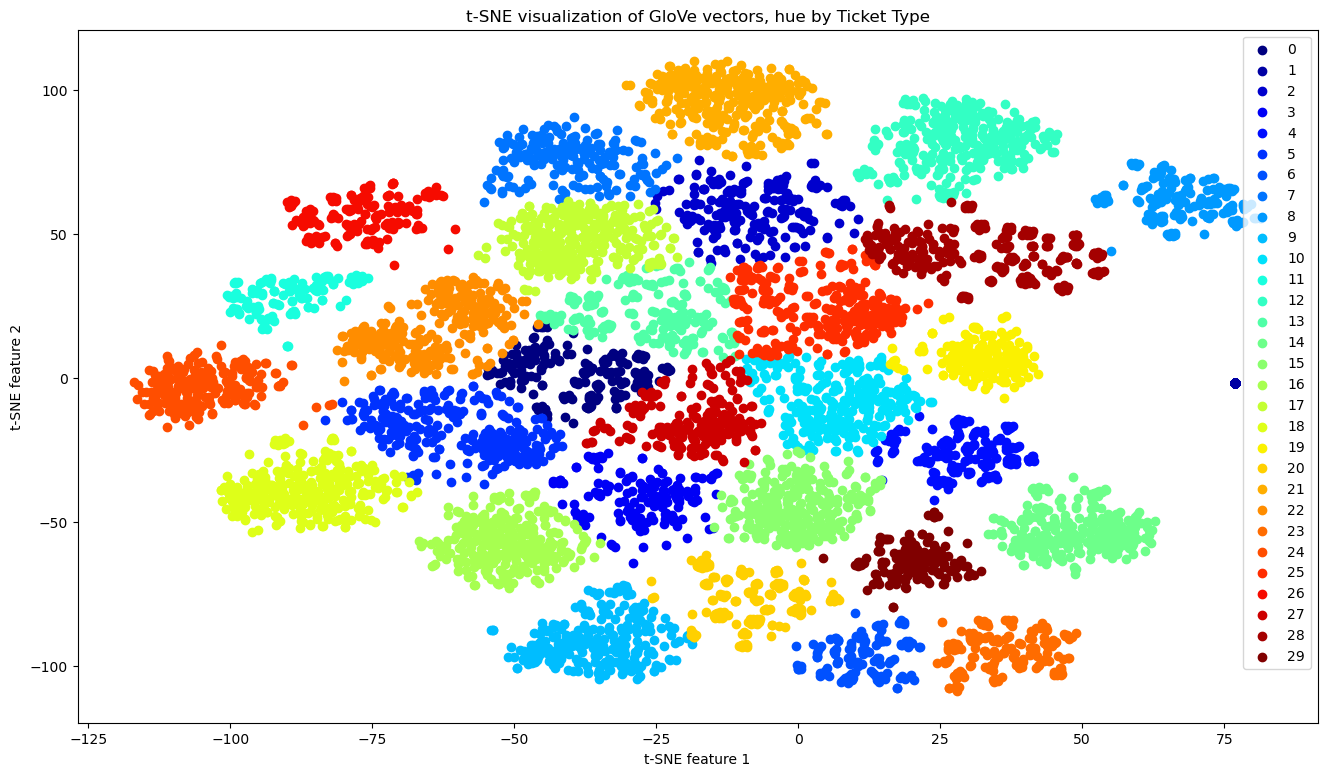

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Extract ticket types corresponding to the order of documents in the GloVe transformation
ticket_types = cleaned_df['Cluster'].values  # Assuming order is the same

# Map each unique ticket type to a color
unique_ticket_types = np.unique(ticket_types)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_ticket_types)))  # Generate colors
color_map = dict(zip(unique_ticket_types, colors))  # Create a mapping of ticket type to color

# Plotting
plt.figure(figsize=(16, 9))
for ticket_type in unique_ticket_types:
    idx = np.where(ticket_types == ticket_type)  # Find indices of each ticket type
    plt.scatter(tsne_glove[idx, 0], tsne_glove[idx, 1], label=ticket_type, color=color_map[ticket_type])

plt.title('t-SNE visualization of GloVe vectors, hue by Ticket Type')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()


# K Means Clustering GloVe vectors

In [149]:
from sklearn.cluster import KMeans

# Number of clusters
k = 30  # Adjust based on your visual inspection of the t-SNE plot

# Apply K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(tsne_glove)

# Add the cluster labels to your DataFrame
cleaned_df['Cluster'] = clusters


/var/folders/_x/3hvhfs550_j07qx5c00fkgnc0000gn/T/ipykernel_79040/3213886428.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Cluster'] = clusters


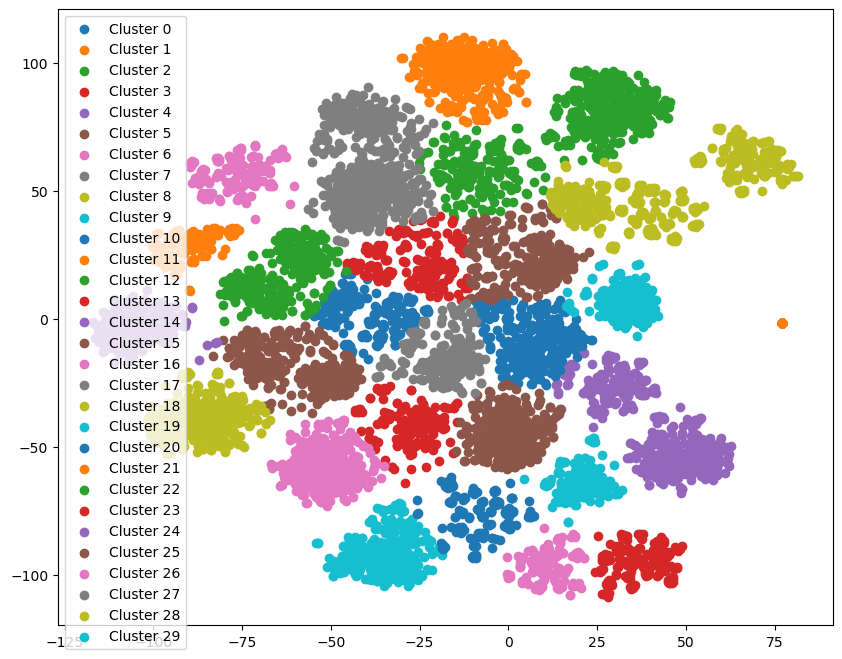

In [150]:
plt.figure(figsize=(10, 8))
for i in range(k):
    idx = cleaned_df['Cluster'] == i
    plt.scatter(tsne_glove[idx, 0], tsne_glove[idx, 1], label=f'Cluster {i}')
plt.legend()
plt.show()


In [151]:
for i in range(k):
    print(f'Examples from Cluster {i}:')
    sample_tickets = cleaned_df[cleaned_df['Cluster'] == i]['Ticket Description'].sample(n=1, random_state=42)  # Adjust n as needed
    for ticket in sample_tickets:
        print(f'- {ticket}')
    print('\n')


Examples from Cluster 0:
- i'm having an issue with the asus rog. please assist.

note this issue is being reported to the product team. please report it to their support team.

1.3: support

- fixed support i've noticed that the issue occurs consistently when i use a specific feature or application on my asus rog.


Examples from Cluster 1:
- i'm having an issue with the philips hue lights. please assist. please, i need to know for what? (sorry, don't have the url yet, but it's not too bad).

if this issue doesn't i've tried different settings and configurations on my philips hue lights, but the issue persists.


Examples from Cluster 2:
- i'm encountering a software bug in the lg smart tv. whenever i try to perform a specific action, the application crashes. are there any updates or fixes available?

microsoft is committed to delivering a clean product experience, a secure i've checked the device settings and made sure that everything is configured correctly.


Examples from Cluster 

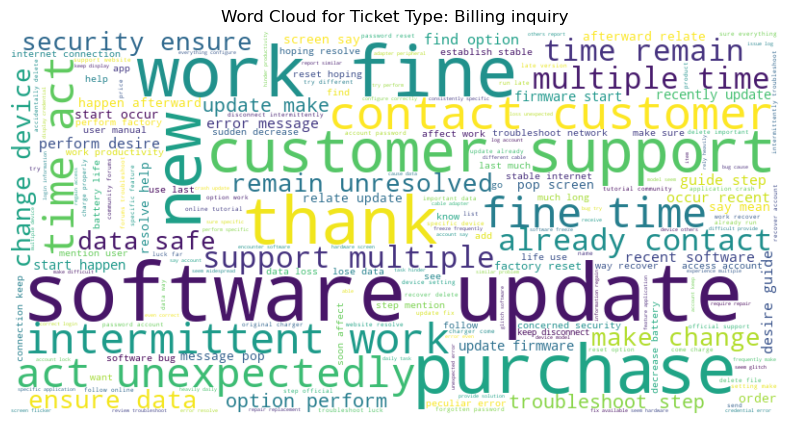

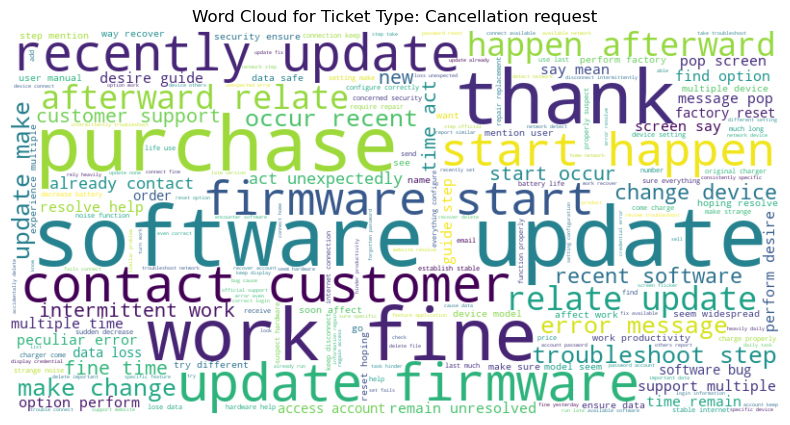

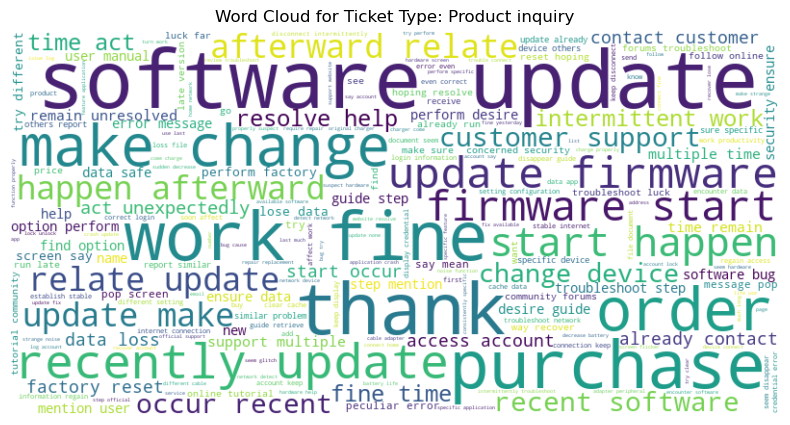

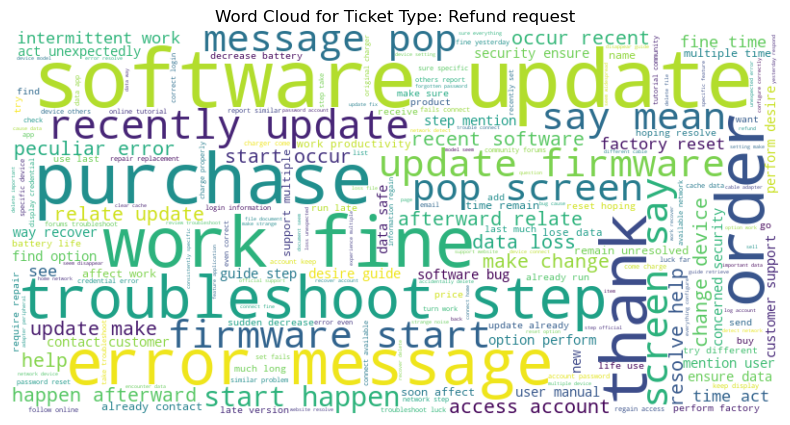

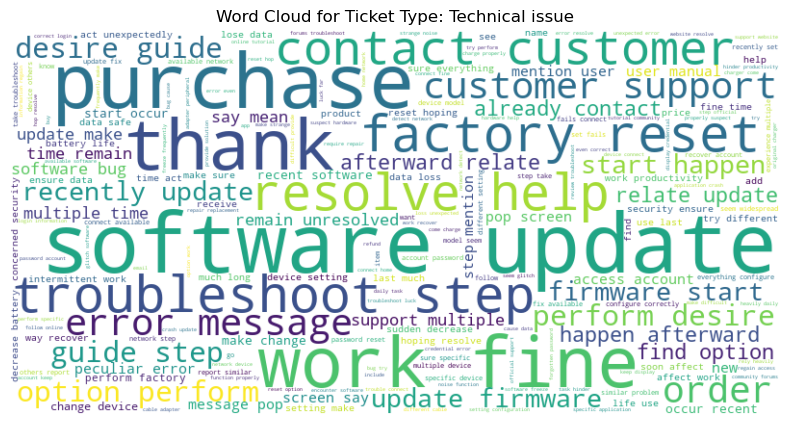

In [152]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Group by 'Ticket Type' and concatenate 'Ticket Description'
grouped_data = cleaned_df.groupby('Ticket Type')['Ticket Description Cleaned'].apply(lambda x: ' '.join(x)).reset_index()

# Generate a word cloud for each ticket type
for index, row in grouped_data.iterrows():
    ticket_type = row['Ticket Type']
    text = row['Ticket Description Cleaned']
    
    # Generate the word cloud
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Ticket Type: {ticket_type}')
    plt.axis('off')
    plt.show()


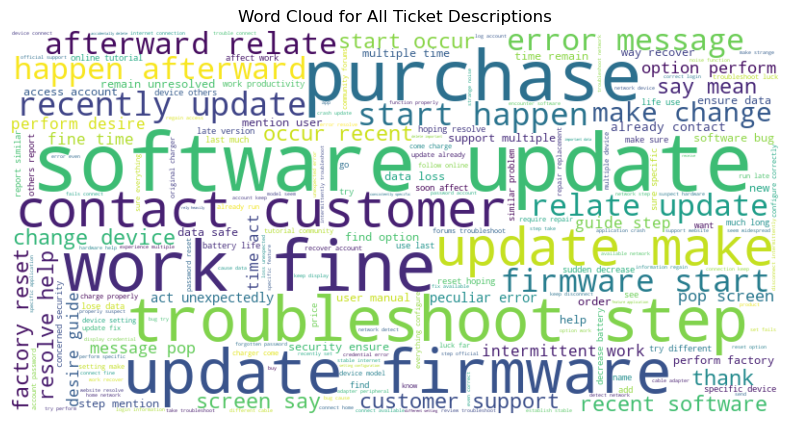

In [153]:
all_text = ' '.join(cleaned_df['Ticket Description Cleaned'])

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for All Ticket Descriptions')
plt.axis('off')
plt.show()